In [231]:
from enum import Enum
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

from geopy.geocoders import ArcGIS
from geopy.geocoders import Nominatim
import folium

import io
from PIL import Image

import plotly.graph_objects as go
# from plotly.subplots import make_subplot

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

In [6]:
class In(Enum):
    SINGAPORE = 0
    SAN_FRANCISCO = 1
    COSTS = 2
    DIST = 3

### mobility data

In [7]:
cols = ["districts", "dist_public", "dist_driving", "dist_walking", "dist_cycling", "cost_bus","cost_subway", "cost_driving", "cost_cycling", "cost_walking"]

def read_sheet(city):
    if city == In.SINGAPORE:
        header=2
        nrows=31
    else:
        header=38
        nrows=37
    df = pd.read_excel("sheets/mobility_qol.xlsx", sheet_name=0, header=header, usecols="E, I:Q", nrows=nrows)
    df.columns = cols
    df.drop(0, inplace=True)

    return df 

In [8]:
sing_df = read_sheet(In.SINGAPORE)
sf_df = read_sheet(In.SAN_FRANCISCO)
sf_df.head()

,districts,dist_public,dist_driving,dist_walking,dist_cycling,cost_bus,cost_subway,cost_driving,cost_cycling,cost_walking
1,Bernal Heights,3.938473,26.517003,1.940619,5.829403,0.09,0.09,0.28,0.44,0.51
2,Castro/Upper Market,0.000000,0.000000,0.000000,0.000000,0.10,0.10,0.27,0.43,0.57
3,Chinatown,1.179977,15.022439,2.281854,7.834494,0.09,0.09,0.28,0.21,0.23
4,Crocker Amazon,5.642908,21.725930,2.340712,5.078145,0.08,0.08,0.29,0.48,0.48
5,Diamond Heights/Glen Park,8.617236,24.357509,2.215848,5.767667,0.09,0.09,0.28,0.48,0.55


### location data

In [85]:
def get_spatial_data(city):  
    city_name = "singapore" if city == In.SINGAPORE else "san francisco"
    path = f"{city_name}/coords.csv"
    coords_df = pd.read_csv(path)

    if city == In.SAN_FRANCISCO:
        mask = (coords_df['Longitude'] <= -122) & (coords_df['Latitude'] >= 37)
        coords_df = coords_df.loc[mask].reset_index(drop=True)
        
    if city == In.SINGAPORE:
        coords_df.drop(30, inplace=True)
    
    # reorganize and rename columns as needed 
    coords_df = coords_df[["Unnamed: 0",  "Latitude", "Longitude",]]
    coords_df.rename(columns={"Unnamed: 0": "districts"}, inplace=True)

    # k means 
    np_data = coords_df.iloc[:, 1:].to_numpy()
    kmeans = KMeans(n_clusters=4, n_init="auto").fit(np_data)

    # plot k means 
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=coords_df["Latitude"], 
        y=coords_df["Longitude"],
        mode='markers',
        marker=dict(
            color=kmeans.labels_,
            showscale=True,
            size=16
        )
    ))

    coords_df["space_group"] = kmeans.labels_

    return coords_df, fig
    # districts = list(districts_df[city])
    # coords = {}

In [195]:
sdf, fig = get_spatial_data(In.SINGAPORE)
sdf.head()

,districts,Latitude,Longitude,space_group
0,Ang Mo Kio,1.370080,103.849523,0
1,Bedok,1.323976,103.930216,1
2,Bishan,1.350986,103.848255,0
3,Bukit Batok,1.349057,103.749591,3
4,Bukit Merah,1.283736,103.820100,0


In [228]:
colors = ["blue", 'orange', 'green', "red"]
colors_dict = {k:v for k,v in enumerate(colors)}
sdf_colors = sdf["space_group"].apply(lambda x: colors_dict[x])

#### map 

In [229]:
markers = [folium.Marker(location=[lat, long],popup=name,icon=folium.Icon(color=color)) for lat, long, name, color in zip(sdf["Latitude"],  sdf["Longitude"], sdf["districts"], sdf_colors )]

In [174]:
# nom=ArcGIS()
# nom.geocode("Singapore")

Location(Singapore, (1.2908800000000724, 103.85239000000007, 0.0))

In [208]:
geolocator = Nominatim(user_agent="location_details")
location = geolocator.geocode("Singapore")
sing_loc = (location.latitude, location.longitude)

In [230]:
map=folium.Map(location=sing_loc,zoom_start=12)
for i in markers:
    map.add_child(i)
# map.add_child(folium.Marker(location=[28.518580000000043,77.27589000000006],popup='Tughlakabad',icon=folium.Icon(color='green')))
map

In [233]:
# m = map
# img_data = m._to_png(5)
# img = Image.open(io.BytesIO(img_data))
# img.save('figures/sing_map.png')

SessionNotCreatedException: Message: Expected browser binary location, but unable to find binary in default location, no 'moz:firefoxOptions.binary' capability provided, and no binary flag set on the command line


### scatterplot matrix

In [88]:
def merge_data(df_coords, df_mob):
    df = pd.merge(df_mob, df_coords,  on=['districts'], how='inner')
    return df

In [90]:
sdfm = merge_data(sdf, sing_df)
sdfm.head()

,districts,dist_public,dist_driving,dist_walking,dist_cycling,cost_bus,cost_subway,cost_driving,cost_cycling,cost_walking,Latitude,Longitude,space_group
0,Ang Mo Kio,9.858630,15.657752,2.151090,6.871619,0.11,0.05,0.28,0.24,0.23,1.370080,103.849523,0
1,Bedok,10.059388,22.070729,2.237446,6.347449,0.12,0.06,0.29,0.21,0.20,1.323976,103.930216,3
2,Bishan,11.035620,18.032546,2.070017,6.708787,0.12,0.06,0.28,0.19,0.16,1.350986,103.848255,0
3,Bukit Batok,9.374971,17.891579,2.206020,5.206920,0.11,0.05,0.28,0.22,0.19,1.349057,103.749591,2
4,Bukit Merah,6.132163,14.658450,2.177206,6.841563,0.13,0.06,0.30,0.21,0.22,1.283736,103.820100,1


In [226]:
def mob_plot(an_df):
    
    sns.set()
    palette = sns.color_palette("bright")
    n_rows=4
    n_cols=1
    # Create the subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=[10,9], sharex=True )

    column_names = ["Public Transport", "Driving", "Walking", "Cycling"]

    for (i, column), name in zip(enumerate(an_df.columns[0:4]), column_names):
        g = sns.kdeplot(an_df, x=column ,ax=axes[i], hue="space_group", fill=True, palette=palette )
        axes[i].set_title(name)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")
        if i != 0:
            axes[i].get_legend().remove()
        elif i == 0:
            axes[i].get_legend().set_title("Area")
    
    return fig



def distance_plot(df, type=None):
    if type == In.COSTS:
        an_df = df.iloc[:, 5:]
    elif type == In.DIST:
        an_df = df.iloc[:, 1:5]
    else:
        an_df = df.iloc[:, 1:]
    
    an_df["space_group"] = df["space_group"]
    # return an_df

    # s = sns.pairplot(an_df, hue="space_group")
    s = mob_plot(an_df)
    
    return (s, an_df)

/var/folders/7r/39t1cgb13d57zk26c__2z50m0000gn/T/ipykernel_26168/1329170122.py:13: UserWarning:

The palette list has more values (10) than needed (4), which may not be intended.

/var/folders/7r/39t1cgb13d57zk26c__2z50m0000gn/T/ipykernel_26168/1329170122.py:13: UserWarning:

The palette list has more values (10) than needed (4), which may not be intended.

/var/folders/7r/39t1cgb13d57zk26c__2z50m0000gn/T/ipykernel_26168/1329170122.py:13: UserWarning:

The palette list has more values (10) than needed (4), which may not be intended.

/var/folders/7r/39t1cgb13d57zk26c__2z50m0000gn/T/ipykernel_26168/1329170122.py:13: UserWarning:

The palette list has more values (10) than needed (4), which may not be intended.



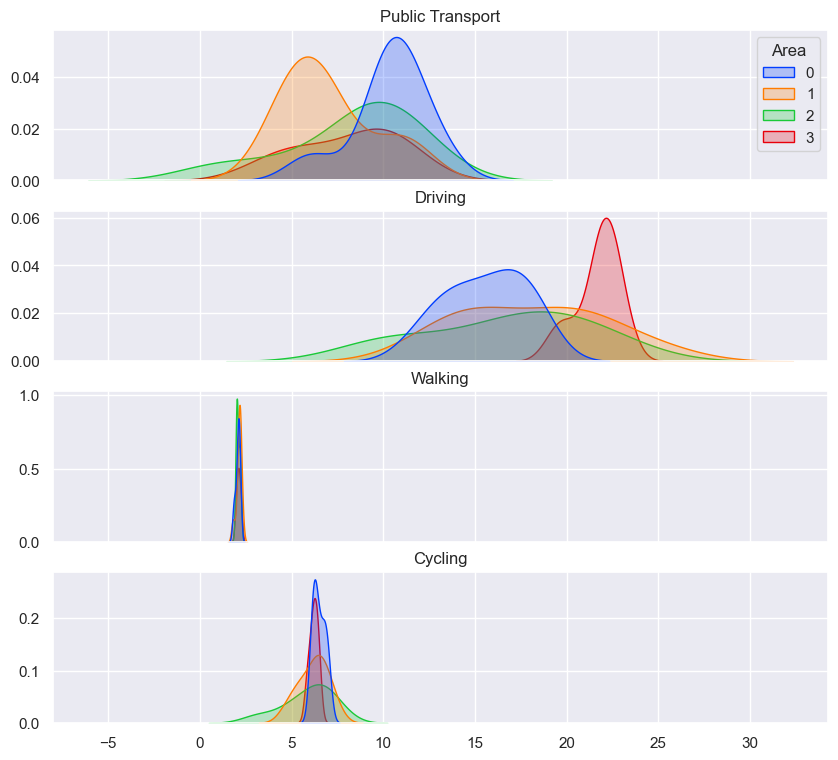

In [227]:
s, df2 = distance_plot(sdfm, In.DIST)

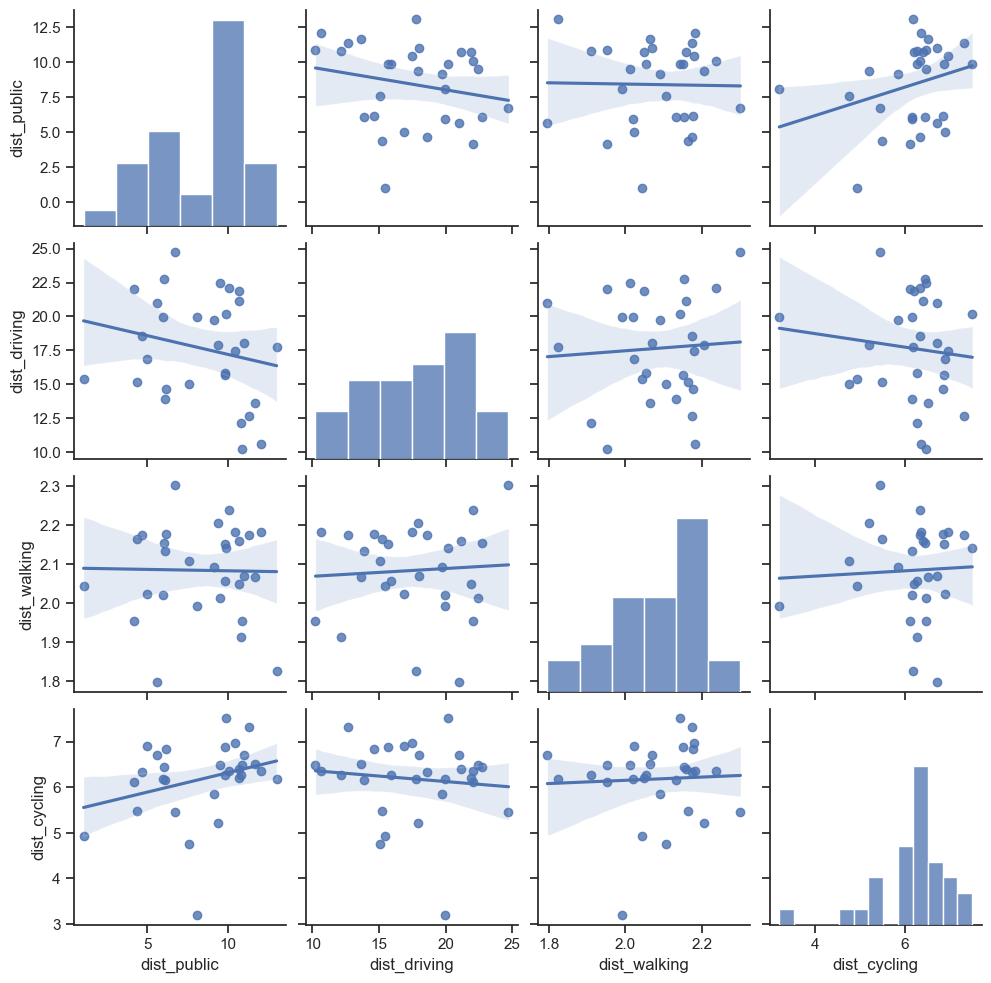

In [163]:
g = sns.pairplot(an_df.iloc[:, 0:-1],  kind="reg")
